Taken from https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3 but using a different custom dataset

## Introduction

Small definition of time series:
Time series — is a series of data points indexed (or listed or graphed) in time order.
Therefore data is organized around relatively deterministic timestamps, and therefore, compared to random samples, may contain additional information that we will try to extract.
Let’s import some libraries. First and foremost we will need statsmodels library that has tons of statistical modeling functions, including time series. For R afficionados (that had to move to python) statsmodels will definitely look familiar as it supports model definitions like ‘Wage ~ Age + Education’.

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('../Features.csv', parse_dates=['Timestamp'], index_col='Timestamp')

In [3]:
df.drop(['Unnamed: 0'],axis=1, inplace=True)

In [4]:
slice_df = df[df['Module']=='00.57.FE.05'][['Temp_Mod', 'VBus']]
slice_df.head()

,Temp_Mod,VBus
Timestamp,,
2017-12-01 20:28:07,31.1,5.291
2017-12-01 20:29:58,31.7,5.291
2017-12-01 20:31:58,32.3,5.296
2017-12-01 20:33:58,32.5,5.296
2017-12-01 20:35:58,32.7,5.296


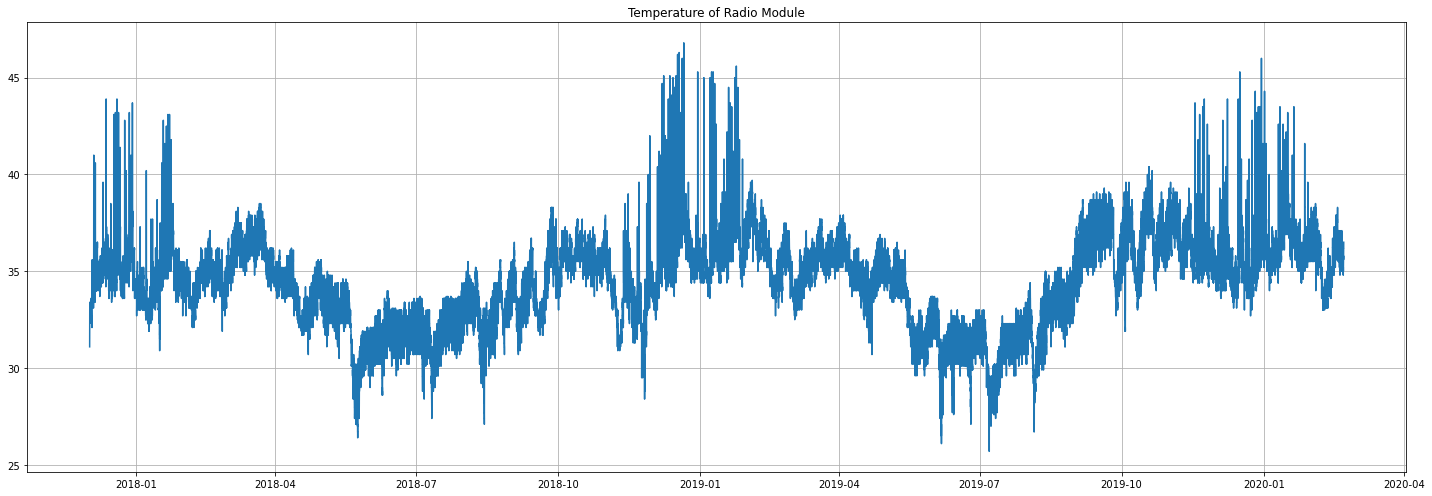

In [5]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20,7))
ax1.plot(slice_df.Temp_Mod)
ax1.set_title('Temperature of Radio Module')
ax1.grid(True)
plt.tight_layout()

Now let's resample the data to a fixed frequency. Let's say hourly and take only the temperature value.

In [6]:
slice_df = slice_df.resample('60Min').mean()
slice_df = slice_df.fillna(slice_df.bfill())

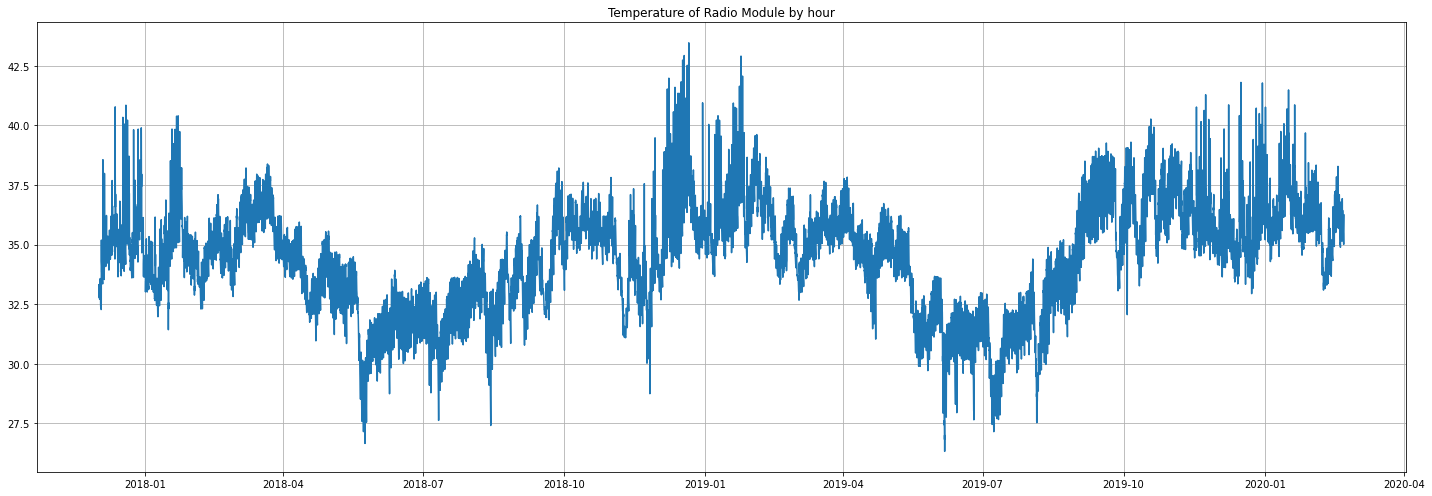

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20,7))
ax1.plot(slice_df.Temp_Mod)
ax1.set_title('Temperature of Radio Module by hour')
ax1.grid(True)
plt.tight_layout()

### Forecast quality metrics

Before actually forecasting, let’s understand how to measure the quality of predictions and have a look at the most common and widely used metrics.

- R squared, coefficient of determination (in econometrics it can be interpreted as a percentage of variance explained by the model), (-inf, 1] sklearn.metrics.r2_score
- Mean Absolute Error, it is an interpretable metric because it has the same unit of measurement as the initial series, [0, +inf) sklearn.metrics.mean_absolute_error
- Median Absolute Error, again an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)sklearn.metrics.median_absolute_error
- Mean Squared Error, most commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf) sklearn.metrics.mean_squared_error
- Mean Squared Logarithmic Error, practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends, [0, +inf) sklearn.metrics.mean_squared_log_error
- Mean Absolute Percentage Error, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management, [0, +inf), not implemented in sklearn

In [8]:
# Importing everything from above
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Move, smoothe, evaluate

Let’s start with a naive hypothesis — “tomorrow will be the same as today”, but instead of a model like ŷ(t)=y(t−1) (which is actually a great baseline for any time series prediction problems and sometimes it’s impossible to beat it with any model) we’ll assume that the future value of the variable depends on the average n of its previous values and therefore we’ll **use moving average.**

In [9]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(slice_df.Temp_Mod, 24) # prediction for the last observed day (past 24 hours)

35.58964915908465

Unfortunately we can’t make this prediction long-term — to get one for the next step we need the previous value to be actually observed. But moving average has another use case — smoothing of the original time series to indicate trends. Pandas has an implementation available `DataFrame.rolling(window).mean()`. The wider the window - the smoother will be the trend. In the case of the very noisy data, which can be very often encountered in finance, this procedure can help to detect common patterns.

In [10]:
def plotMovingAverage(series, window=4, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

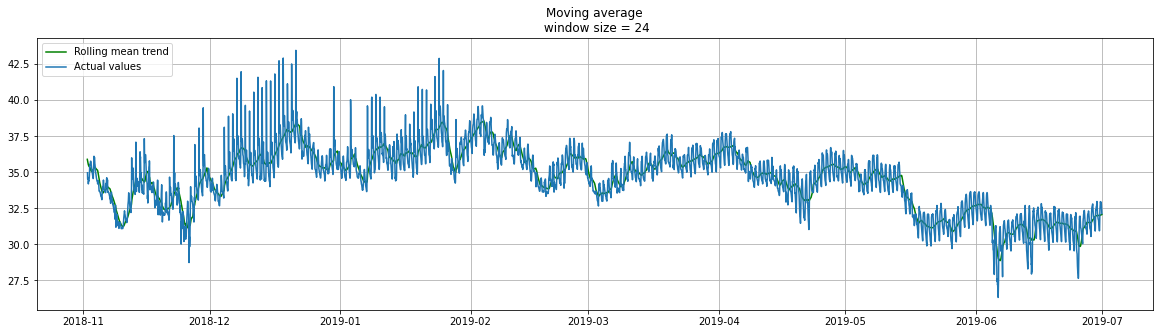

In [82]:
# Let's take a little zoom to see better the moving average
# smothing by 24 hours
plotMovingAverage(slice_df['Temp_Mod']['2018-11':'2019-06'], 24)

As you can see, applying daily smoothing on hour data allowed us to clearly see the dynamics of ads watched.

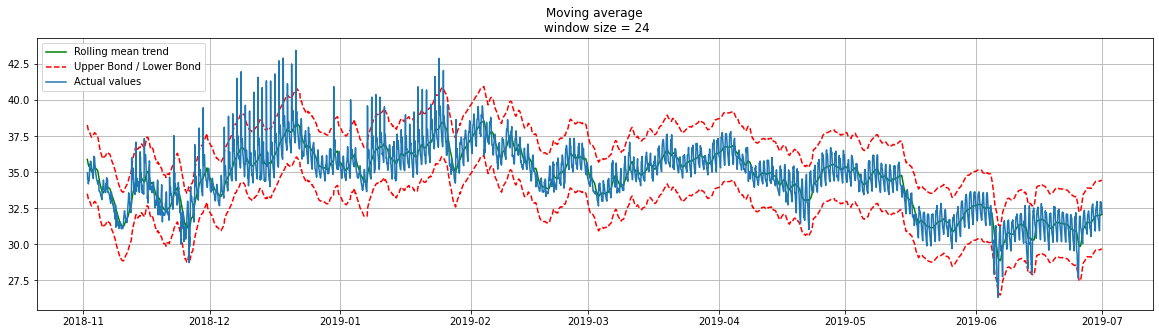

In [83]:
plotMovingAverage(slice_df['Temp_Mod']['2018-11':'2019-06'], 24, plot_intervals=True)

And now let’s create a simple anomaly detection system with the help of the moving average. Unfortunately, in this particular series everything is more or less normal, so we’ll intentionally make one of the values abnormal in the dataframe ads_anomaly

In [11]:
temp_anomaly = slice_df['2018-11':'2019-06'].copy()
temp_anomaly.iloc[-20] = temp_anomaly.iloc[-20] * 0.8 # say we have 20% drop of temp 

Let’s see, if this simple method can catch the anomaly

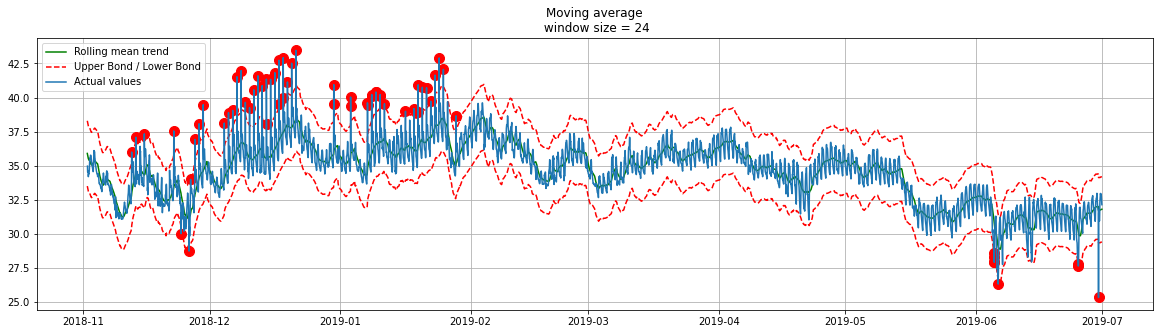

In [85]:
plotMovingAverage(temp_anomaly[['Temp_Mod']], 24, plot_intervals=True, plot_anomalies=True)

Weighted average is a simple modification of the moving average, inside of which observations have different weights summing up to one, usually more recent observations have greater weight.

In [12]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)
  
weighted_average(slice_df['Temp_Mod']['2018-11':'2019-06'], [0.6, 0.3, 0.1])

32.44866666666666

### Exponential smoothing
And now let’s take a look at what happens if instead of weighting the last nn values of the time series we start weighting all available observations while exponentially decreasing weights as we move further back in historical data. There’s a formula of the simple exponential smoothing that will help us in that.

<img src="images\\exponential.png" style="width:400px;heigth:400px"/> 

Exponentiality is hiding in the recursivity of the function — we multiply each time (1−α) by the previous model value which, in its turn, also containes (1−α) and so forth until the very beginning.

In [13]:
serie = slice_df['Temp_Mod']['2018-11':'2019-02']

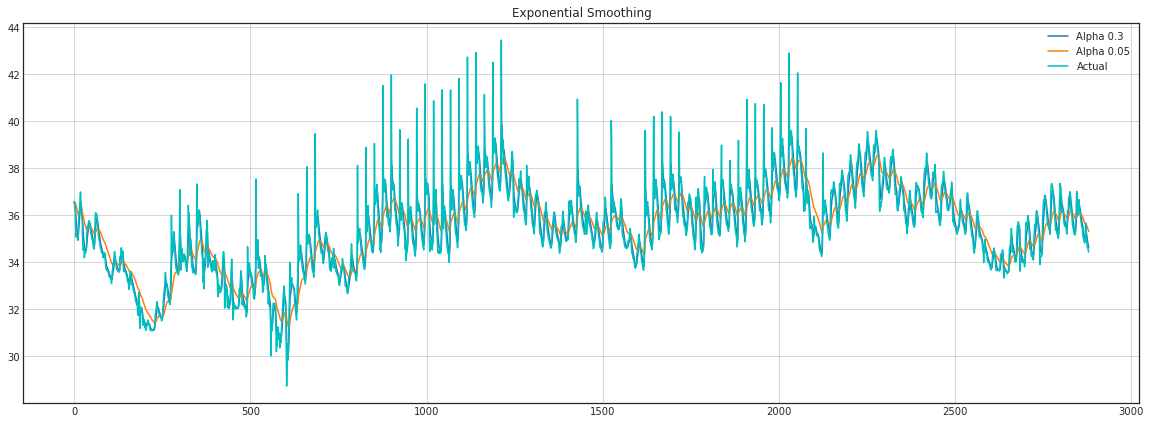

In [14]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        
plotExponentialSmoothing(serie, [0.3, 0.05])

### Double exponential smoothing
Until now all we could get from our methods in the best case was just a single future point prediction (and also some nice smoothing), that’s cool but not enough, so let’s extend exponential smoothing so that we can predict two future points (of course, we also get some smoothing).

Series decomposition should help us — we obtain two components: intercept (also, level) ℓ and trend (also, slope) b. We’ve learnt to predict intercept (or expected series value) using previous methods, and now we will apply the same exponential smoothing to the trend, believing naively or perhaps not that the future direction of the time series changes depends on the previous weighted changes.

<img src="images\\double_exponential.png" style="width:600px;heigth:400px"/> 

As a result we get a set of functions. The first one describes intercept, as before it depends on the current value of the series, and the second term is now split into previous values of the level and of the trend. The second function describes trend — it depends on the level changes at the current step and on the previous value of the trend. In this case β coefficient is a weight in the exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [15]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

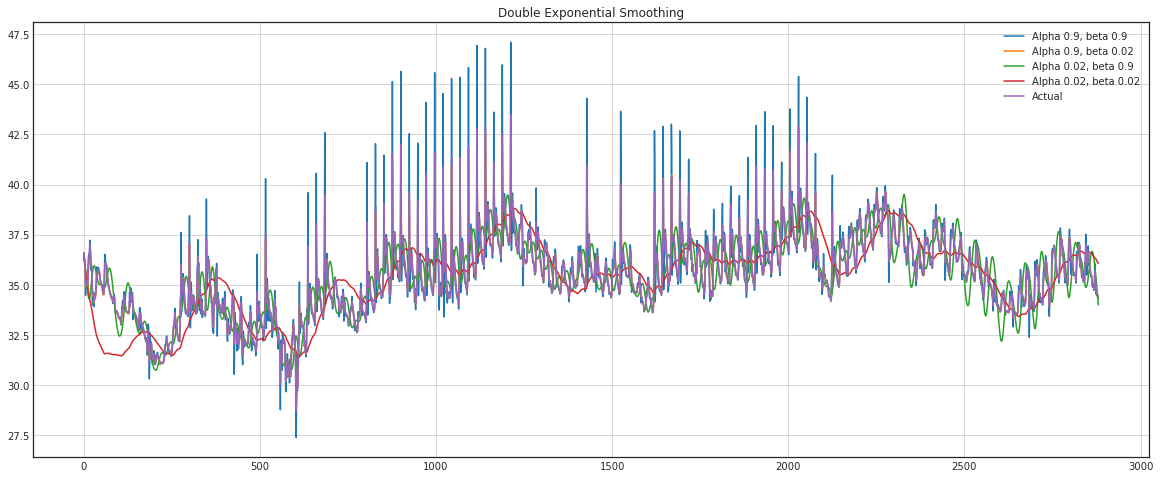

In [100]:
plotDoubleExponentialSmoothing(serie, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Now we have to tune two parameters — α and β. The former is responsible for the series smoothing around trend, and the latter for the smoothing of the trend itself. The bigger the values, the more weight the latest observations will have and the less smoothed the model series will be. Combinations of the parameters may produce really weird results, especially if set manually. We’ll look into choosing parameters automatically in a bit, immediately after triple exponential smoothing.

### Triple exponential smoothing a.k.a. Holt-Winters
Hooray! We’ve successfully reached our next variant of exponential smoothing, this time triple.
The idea of this method is that we add another, third component — seasonality. This means we should’t use the method if our time series do not have seasonality, which is not the case in our example. Seasonal component in the model will explain repeated variations around intercept and trend, and it will be described by the length of the season, in other words by the period after which variations repeat. For each observation in the season there’s a separate component, for example, if the length of the season is 7 (weekly seasonality), we will have 7 seasonal components, one for each day of the week.

Now we get a new system:

<img src="images\\1_tQUjJKDKmqjGPeQ9YqV_dQ.png" style="width:600px;heigth:400px"/> 

Intercept now depends on the current value of the series minus corresponding seasonal component, trend stays unchanged, and the seasonal component depends on the current value of the series minus intercept and on the previous value of the component. Please take into account that the component is smoothed through all the available seasons, for example, if we have a Monday component then it will only be averaged with other Mondays. You can read more on how averaging works and how initial approximation of the trend and seasonal components is done here. Now that we have seasonal component we can predict not one and not even two but arbitrary mm future steps which is very encouraging.

Below is the code for a triple exponential smoothing model, also known by the last names of its creators — Charles Holt and his student Peter Winters. Additionally Brutlag method was included into the model to build confidence intervals:

<img src="images\\triple_exponential.png" style="width:600px;heigth:400px"/> 

where T is the length of the season, d is the predicted deviation, and the other parameters were taken from the triple exponential smoothing. You can read more about the method and its applicability to anomalies detection in time series here http://fedcsis.org/proceedings/2012/pliks/118.pdf.

In [16]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

### Time series cross validation
Before we start building model let’s talk first about how to estimate model parameters automatically.

There’s nothing unusual here, as always we have to choose a loss function suitable for the task, that will tell us how close the model approximates data. Then using cross-validation we will evaluate our chosen loss function for given model parameters, calculate gradient, adjust model parameters and so forth, bravely descending to the global minimum of error.

The question is how to do cross-validation on time series, because, you know, time series do have time structure and one just can’t randomly mix values in a fold without preserving this structure, otherwise all time dependencies between observations will be lost. That’s why we will have to use a bit more tricky approach to optimization of the model parameters, I don’t know if there’s an official name to it but on CrossValidated, where one can find all the answers but the Answer to the Ultimate Question of Life, the Universe, and Everything, “cross-validation on a rolling basis” was proposed as a name.
The idea is rather simple — we train our model on a small segment of the time series, from the beginning until some t, make predictions for the next t+n steps and calculate an error. Then we expand our training sample until **t+n** value and make predictions from **t+n** until **t+2∗n**, and we continue moving our test segment of the time series until we hit the last available observation. As a result we have as many folds as many n will fit between the initial training sample and the last observation.

<img src="images\\crossval.png" style="width:600px;heigth:400px"/>

Now, knowing how to set cross-validation, we will find optimal parameters for the Holt-Winters model, recall that we have daily seasonality, hence the `slen=24` parameter

In [17]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there’s a constraint on how big smoothing parameters could be, each of them is in the range from 0 to 1, therefore to minimize loss function we have to choose an algorithm that supports constraints on model parameters, in our case — Truncated Newton conjugate gradient.

In [128]:
%%time
data = serie[:-20] # leave some data for testing
slen = 24

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.04597786850492719 0.004479009619536067 0.3033465053946451
Wall time: 19.5 s


In [129]:
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

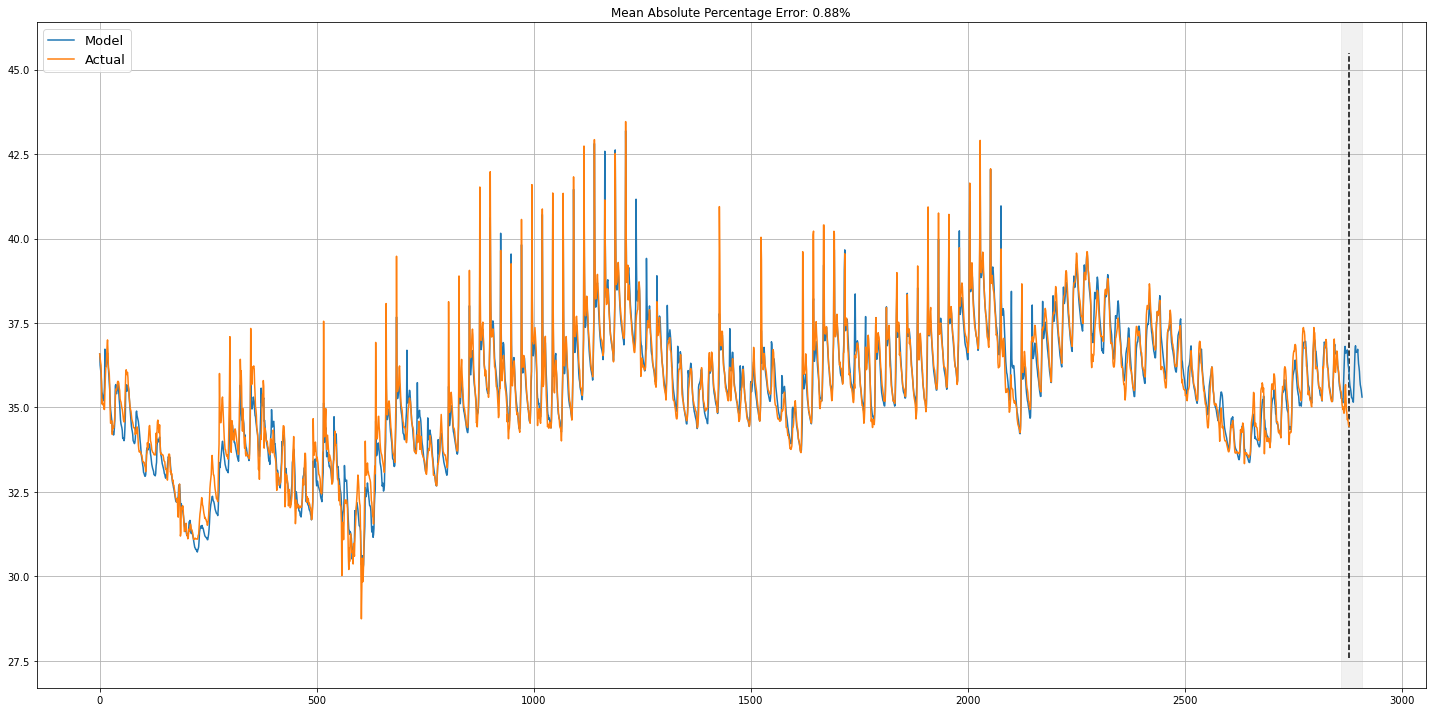

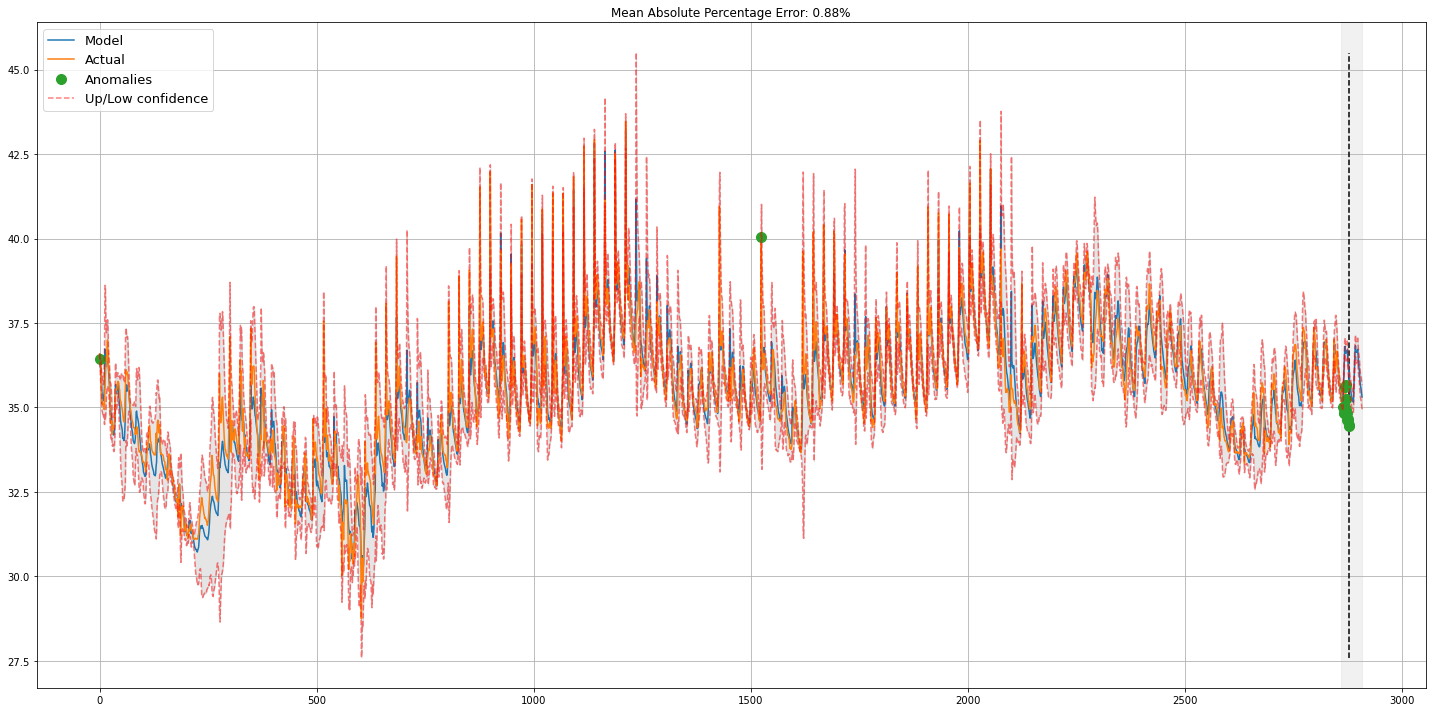

In [130]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    plt.tight_layout()
    
plotHoltWinters(serie)
plotHoltWinters(serie, plot_intervals=True, plot_anomalies=True)

Judging by the chart, our model was able to successfully approximate the initial time series, catching daily seasonality, overall downwards trend and even some anomalies. If you take a look at the modeled deviation, you can clearly see that the model reacts quite sharply to the changes in the structure of the series but then quickly returns deviation to the normal values, “forgetting” the past. This feature of the model allows us to quickly build anomaly detection systems even for quite noisy series without spending too much time and money on preparing data and training the model.

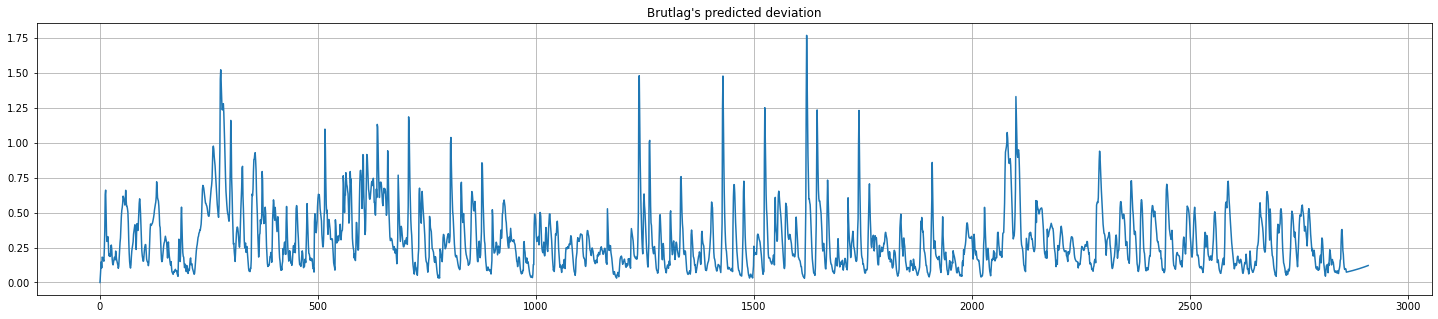

In [131]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

## Econometric approach
Stationarity
Before we start modeling we should mention such an important property of time series as stationarity.
If the process is stationary that means it doesn’t change its statistical properties over time, namely mean and variance do not change over time (constancy of variance is also called homoscedasticity), also covariance function does not depend on the time (should only depend on the distance between observations).

So why stationarity is so important? 

Because it’s easy to make predictions on the stationary series as we assume that the future statistical properties will not be different from the currently observed. Most of the time series models in one way or the other model and predict those properties (mean or variance, for example), that’s why predictions would be wrong if the original series were not stationary. Unfortunately most of the time series we see outside of textbooks are non-stationary but we can (and should) change this.

So, to fight non-stationarity we have to know our enemy so to say. Let’s see how to detect it. To do that we will now take a look at the white noise and random walks and we will learn how to get from one to another for free, without registration and SMS. 

White noise chart:

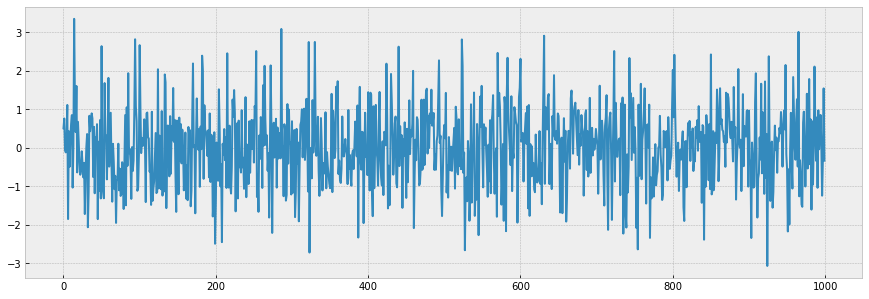

In [18]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

So the process generated by standard normal distribution is stationary and oscillates around 0 with with deviation of 1. Now based on this process we will generate a new one where each next value will depend on the previous one: x(t)=ρ*x(t−1)+e(t)

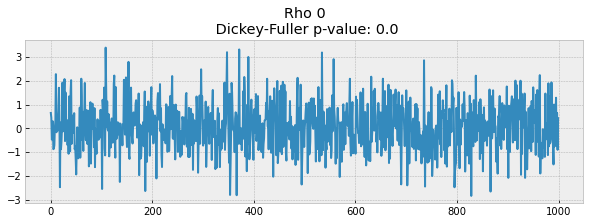

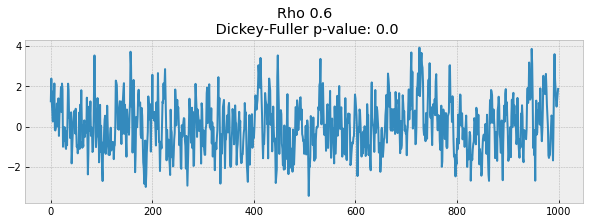

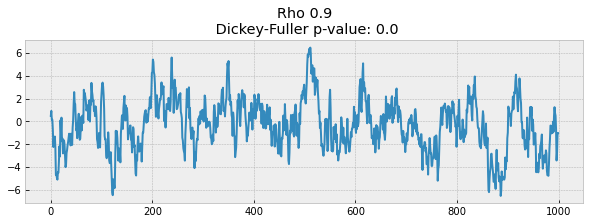

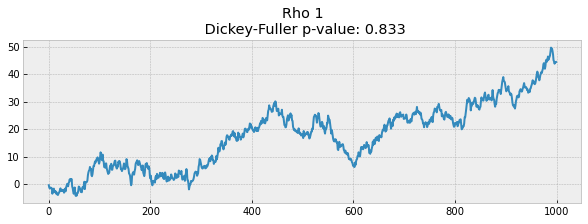

In [19]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

On the first chart you can see the same stationary white noise you’ve seen before. On the second one the value of ρρ increased to 0.6, as a result wider cycles appeared on the chart but overall it is still stationary. The third chart deviates even more from the 0 mean but still oscillates around it. Finally, the value of ρ equal to 1 gives us a random walk process — non-stationary time series.

This happens because after reaching the critical value the series x(t)=ρ*x(t−1)+e(t) does not return to its mean value. If we subtract x(t−1) from the left and the right side we will get x(t)−x(t−1)=(ρ−1)*x(t−1)+e(t), where the expression on the left is called the first difference. If ρ=1 then the first difference gives us stationary white noise e(t). This fact is the main idea of the Dickey-Fuller test for the stationarity of time series (presence of a unit root). If we can get stationary series from non-stationary using the first difference we call those series integrated of order 1. Null hypothesis of the test — time series is non-stationary, was rejected on the first three charts and was accepted on the last one. We’ve got to say that the first difference is not always enough to get stationary series as the process might be integrated of order d, d > 1 (and have multiple unit roots), in such cases the augmented Dickey-Fuller test is used that checks multiple lags at once.

We can fight non-stationarity using different approaches — various order differences, trend and seasonality removal, smoothing, also using transformations like Box-Cox or logarithmic.

### Getting rid of non-stationarity and building SARIMA
Now let’s build an ARIMA model by walking through all the circles of hell stages of making series stationary.

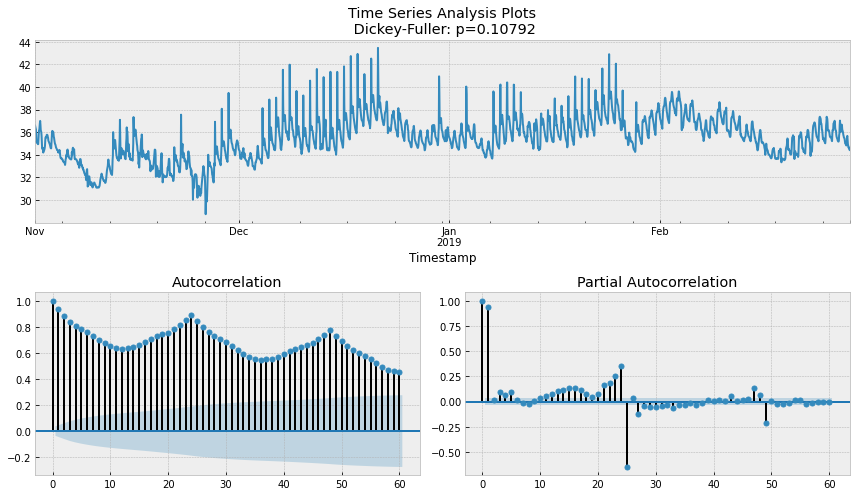

In [20]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(serie, lags=60)

Surprisingly, initial series are stationary, Dickey-Fuller test rejected null hypothesis that a unit root is present. Actually, it can be seen on the plot itself — we don’t have a visible trend, so mean is constant, variance is pretty much stable throughout the series. The only thing left is seasonality which we have to deal with before modelling. To do so let’s take “seasonal difference” which means a simple subtraction of series from itself with a lag that equals the seasonal period.

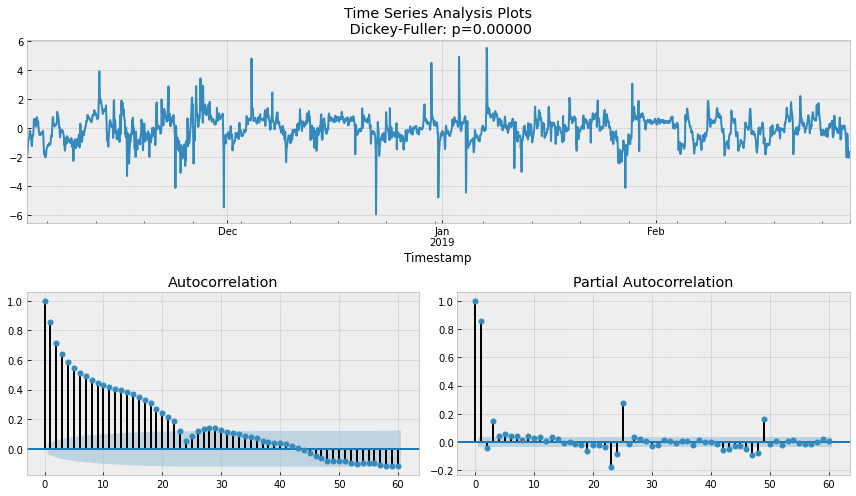

In [21]:
serie_diff = serie - serie.shift(24)
tsplot(serie_diff[24:], lags=60)

That’s better, visible seasonality is gone, however autocorrelation function still has too many significant lags. To remove them we’ll take first differences — subtraction of series from itself with lag 1

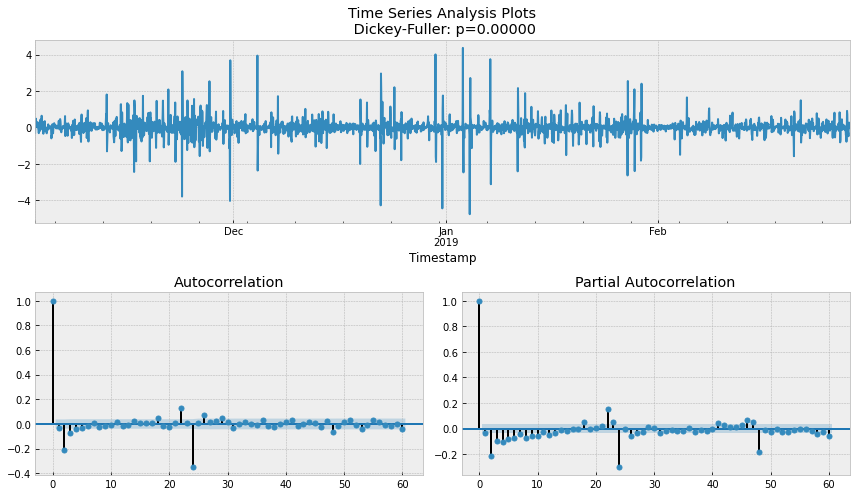

In [22]:
serie_diff = serie_diff - serie_diff.shift(1)
tsplot(serie_diff[24+1:], lags=60)

Perfect! Our series now look like something undescribable, oscillating around zero, Dickey-Fuller indicates that it’s stationary and the number of significant peaks has dropped. We can finally start modelling!

### ARIMA-family Crash-Course
A few words about the model. Letter by letter we’ll build the full name — SARIMA(p,d,q)(P,D,Q,s), Seasonal Autoregression Moving Average model:
- AR(p) — autoregression model, i.e., regression of the time series onto itself. Basic assumption — current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as p. To determine the initial p you need to have a look at PACF plot — find the biggest significant lag, after which most other lags are becoming not significant.
- MA(q) — moving average model. Without going into detail it models the error of the time series, again the assumption is — current error depends on the previous with some lag, which is referred to as q. Initial value can be found on ACF plot with the same logic.

Let’s have a small break and combine the first 4 letters:

- AR(p) + MA(q) = ARMA(p,q)

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with those 4 letters. Shall we continue?

- I(d)— order of integration. It is simply the number of nonseasonal differences needed for making the series stationary. In our case it’s just 1, because we used first differences.

Adding this letter to four previous gives us ARIMA model which knows how to handle non-stationary data with the help of nonseasonal differences. Awesome, last letter left!

- S(s) — this letter is responsible for seasonality and equals the season period length of the series

After attaching the last letter we find out that instead of one additional parameter we get three in a row — (P,D,Q)

- P — order of autoregression for seasonal component of the model, again can be derived from PACF, but this time you need to look at the number of significant lags, which are the multiples of the season period length, for example, if the period equals 24 and looking at PACF we see 24-th and 48-th lags are significant, that means initial P should be 2.
- Q — same logic, but for the moving average model of the seasonal component, use ACF plot
- D — order of seasonal integration. Can be equal to 1 or 0, depending on whether seasonal differences were applied or not

Now, knowing how to set initial parameters, let’s have a look at the final plot once again and set the parameters:

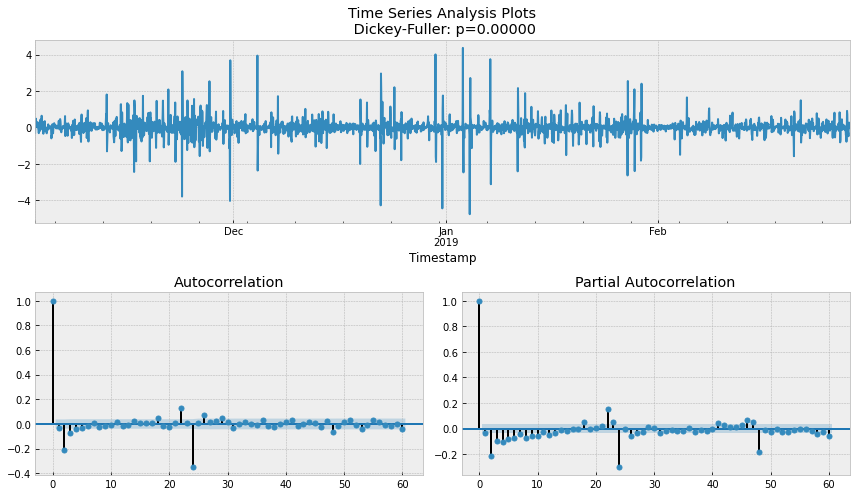

In [23]:
tsplot(serie_diff[24+1:], lags=60)

- p is most probably 4, since it’s the last significant lag on PACF after which most others are becoming not significant.
- d just equals 1, because we had first differences
- q should be somewhere around 4 as well as seen on ACF
- P might be 2, since 24-th and 48-th lags are somewhat significant on PACF
- D again equals 1 — we performed seasonal differentiation
- Q is probably 1, 24-th lag on ACF is significant, while 48-th is not

Now we want to test various models and see which one is better

In [25]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 3)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [24]:
def optimizeSARIMA(parameters_list, d, D, s, serie):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(serie, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s, serie)

In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())